In [1]:
import requests
import pandas as pd
from typing import Dict, List
from dataclasses import dataclass
from datetime import datetime
import json
import matplotlib.pyplot as plt

---

In [2]:
def get_market_snapshots(controller_address: str, 
                         chain: str = "ethereum") -> pd.DataFrame:
    """
    Fetch historical snapshots for a specific crvUSD market
    
    Parameters:
    -----------
    market_obj : Market
        The market address to fetch snapshots for
    chain : str
        The blockchain network (default: "ethereum")
    agg : str
        Aggregation period - 'day' or 'hour' (default: "day")
    """
    
    url = f"https://prices.curve.fi/v1/crvusd/markets/{chain}/{controller_address}/snapshots"
    params = {
        "fetch_on_chain": "false",
        "agg": "day"
    }
    
    response = requests.get(url, params=params)
    response.raise_for_status()
    
    # Convert to DataFrame
    df = pd.DataFrame(response.json()['data'])
    
    # Process DataFrame
    if not df.empty:
        # Convert timestamp to datetime
        df['dt'] = pd.to_datetime(df['dt'])
        df.set_index('dt', inplace=True)
        
        # Convert scientific notation columns to float
        scientific_columns = ['loan_discount', 'liquidation_discount']
        for col in scientific_columns:
            if col in df.columns:
                df[col] = df[col].astype(float)
        
        # Sort by date ascending
        df.sort_index(inplace=True)
    
    df["hhi"] = df["sum_debt_squared"]
    df["hhi_ideal"] = (df["total_debt"]**2)/df["n_loans"]
    df["hhi_ratio"] = df["hhi"]/df["hhi_ideal"]
    
    return df

In [3]:
df = get_market_snapshots("0x4e59541306910ad6dc1dac0ac9dfb29bd9f15c67")

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 396 entries, 2023-10-29 to 2024-11-27
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   rate                  396 non-null    float64
 1   minted                396 non-null    float64
 2   redeemed              396 non-null    float64
 3   total_collateral      396 non-null    float64
 4   total_collateral_usd  396 non-null    float64
 5   total_stablecoin      396 non-null    float64
 6   total_debt            396 non-null    float64
 7   n_loans               396 non-null    int64  
 8   amm_price             396 non-null    float64
 9   price_oracle          396 non-null    float64
 10  base_price            396 non-null    float64
 11  min_band              396 non-null    int64  
 12  max_band              396 non-null    int64  
 13  borrowable            396 non-null    float64
 14  loan_discount         396 non-null    float64
 15  liqu

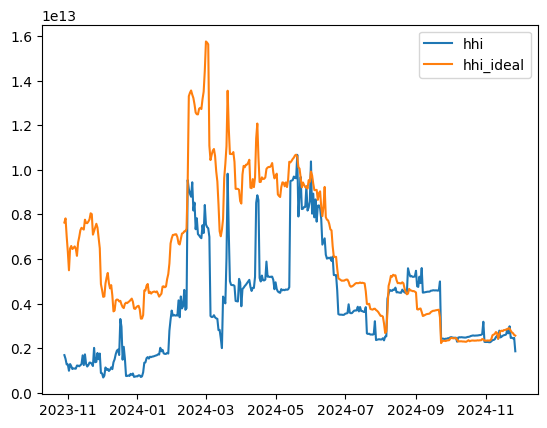

In [4]:
# plot hhi and hhi_ratio
plt.plot(df["hhi"], label="hhi")
plt.plot(df["hhi_ideal"], label="hhi_ideal")
plt.legend()
plt.show()


---

In [33]:
with open('soft_liquidation_events_raw.json', 'r') as file:
    df = json.load(file)


In [80]:
df[0]

{'address': '0x1681195C176239ac5E72d9aeBaCf5b2492E0C4ee',
 'blockHash': '0x52c213e7cc0cd9db5fb9186da2c7c1444ce1dc9dad2cadd5bbb92810359350a6',
 'blockNumber': 20554719,
 'logIndex': 285,
 'removed': False,
 'transactionHash': '0x1324097bde24c596a22450cb09592440431cae6ea9ebb57cfe49deb0c0816f4e',
 'transactionIndex': 84,
 'id': 'log_22ac0ca7',
 'returnValues': {'0': '0x28104d4F703EE5B5011cefe106f54eFd56F33f95',
  '1': '1',
  '2': '1299822141348955919',
  '3': '0',
  '4': '3394259846847306848305',
  'buyer': '0x28104d4F703EE5B5011cefe106f54eFd56F33f95',
  'sold_id': '1',
  'tokens_sold': '1299822141348955919',
  'bought_id': '0',
  'tokens_bought': '3394259846847306848305'},
 'event': 'TokenExchange',
 'signature': '0xb2e76ae99761dc136e598d4a629bb347eccb9532a5f8bbd72e18467c3c34cc98',
 'raw': {'data': '0x00000000000000000000000000000000000000000000000000000000000000010000000000000000000000000000000000000000000000001209e559ce4ac70f0000000000000000000000000000000000000000000000000000000000000

In [43]:
new_df = []

for i in df:
    row = {}
    row["blockNumber"] = i["blockNumber"]
    row["transactionHash"] = i["transactionHash"]
    if i["returnValues"]["sold_id"] == "0" and i["returnValues"]["bought_id"] == "1":
        row["crvUSD"] = float(i["returnValues"]["tokens_sold"])/10**18
        row["collateral"] = float(i["returnValues"]["tokens_bought"])/10**18*-1
    else:
        row["crvUSD"] = float(i["returnValues"]["tokens_bought"])/10**18*-1
        row["collateral"] = float(i["returnValues"]["tokens_sold"])/10**18
    new_df.append(row)


In [39]:
type(df[0]["returnValues"]["sold_id"])



str

In [17]:
new_df[0]

{'blockNumber': 20554719,
 'transactionHash': '0x1324097bde24c596a22450cb09592440431cae6ea9ebb57cfe49deb0c0816f4e',
 'crvUSD': -3394.2598468473066,
 'collateral': 1.299822141348956}

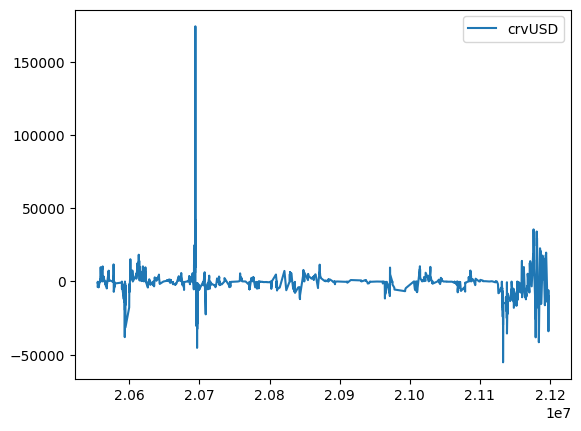

In [44]:
converted_df = pd.DataFrame(new_df)

# Plot crvUSD and collateral
plt.plot(converted_df["blockNumber"], converted_df["crvUSD"], label="crvUSD")
# plt.plot(converted_df["collateral"], label="collateral")
plt.legend()
plt.show()


In [47]:
converted_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1710 entries, 0 to 1709
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   blockNumber      1710 non-null   int64  
 1   transactionHash  1710 non-null   object 
 2   crvUSD           1710 non-null   float64
 3   collateral       1710 non-null   float64
dtypes: float64(2), int64(1), object(1)
memory usage: 53.6+ KB


In [45]:
with open('big_price_oracle_results.json', 'r') as file:
    price_list = json.load(file)
    
price_df = pd.DataFrame(price_list)


In [48]:
price_df.info()
price_df["get_p_diff"] = price_df["get_p"].diff()
price_df["delta"] = price_df["get_p"]-price_df["price_oracle"]
price_df["abs_delta"] = price_df["delta"].abs()


# Join the two dataframes on blockNumber
joined_df = pd.merge(converted_df, price_df, on="blockNumber", how="inner")

joined_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 648001 entries, 0 to 648000
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   blockNumber   648001 non-null  int64  
 1   price_oracle  647378 non-null  float64
 2   get_p         647751 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 14.8 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1487 entries, 0 to 1486
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   blockNumber      1487 non-null   int64  
 1   transactionHash  1487 non-null   object 
 2   crvUSD           1487 non-null   float64
 3   collateral       1487 non-null   float64
 4   price_oracle     1485 non-null   float64
 5   get_p            1487 non-null   float64
 6   get_p_diff       1487 non-null   float64
 7   delta            1485 non-null   float64
 8   abs_delta        1485 non-null   float64
dtypes:

In [79]:
# save joined_df to csv
joined_df.to_csv('joined_df.csv', index=False)



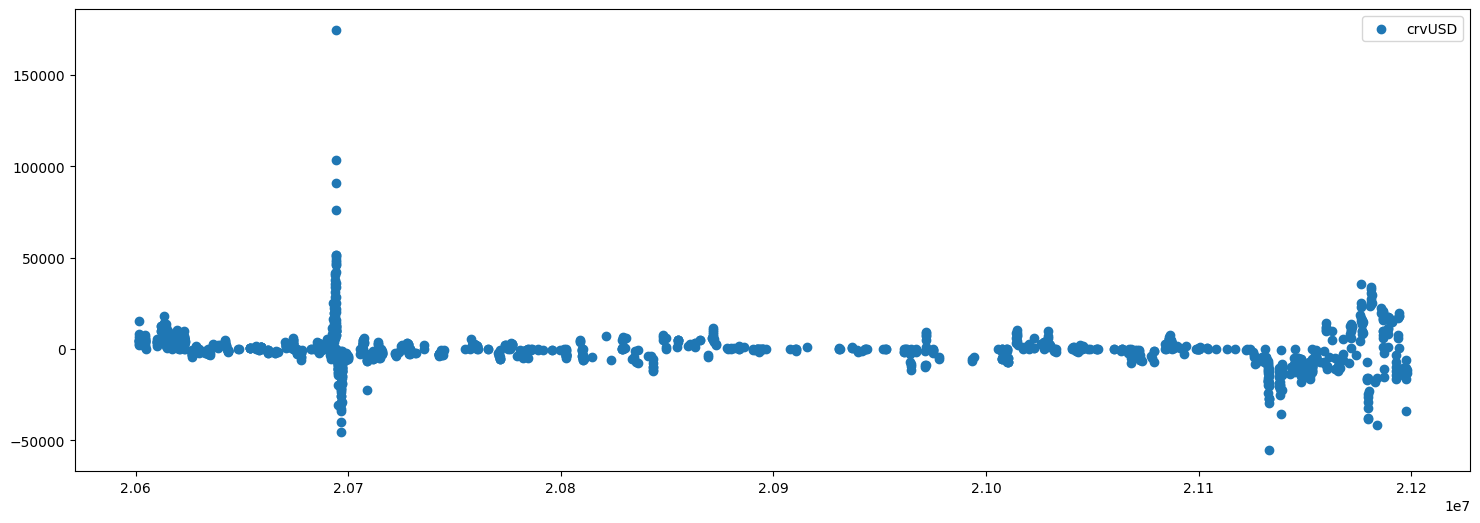

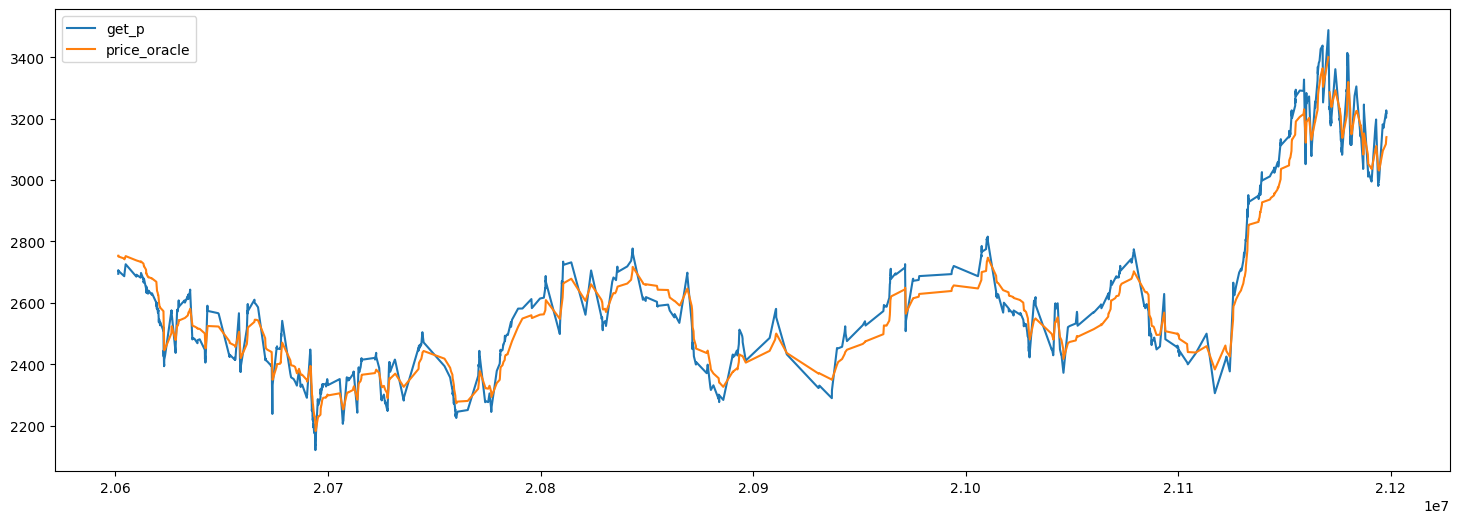

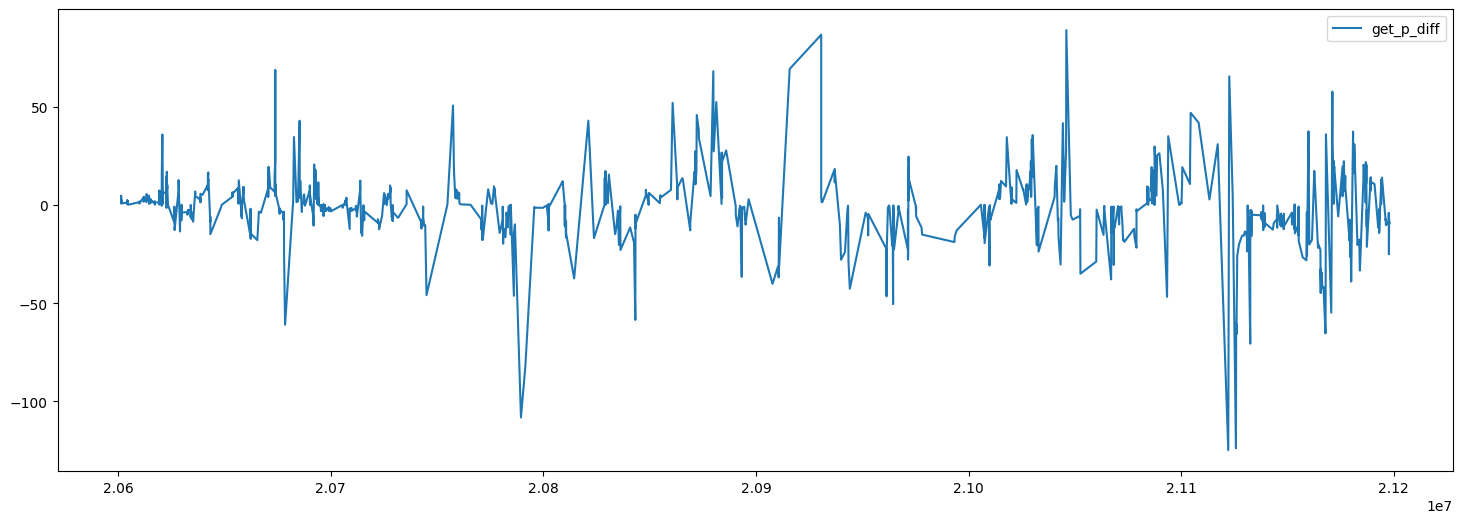

In [55]:
# Plot crvUSD and collateral
# Size of plot
plt.figure(figsize=(18, 6))
plt.plot(joined_df["blockNumber"], joined_df["crvUSD"], label="crvUSD")
plt.legend()
plt.show()

plt.figure(figsize=(18, 6))
plt.plot(joined_df["blockNumber"], joined_df["get_p"], label="get_p")
plt.plot(joined_df["blockNumber"], joined_df["price_oracle"], label="price_oracle")
plt.legend()
plt.show()

plt.figure(figsize=(18, 6))
plt.plot(joined_df["blockNumber"], joined_df["get_p_diff"], label="get_p_diff")
plt.legend()
plt.show()

In [57]:
# Create a new column for incentive
joined_df['incentive'] = 0.0

# Iterate through the dataframe
for idx, row in joined_df.iterrows():
    if row['crvUSD'] > 0:
        joined_df.at[idx, 'incentive'] = -1 * row['collateral'] * row['price_oracle'] - row['crvUSD']
    else:
        joined_df.at[idx, 'incentive'] = -1 * row['crvUSD'] - row['collateral'] * row['price_oracle']

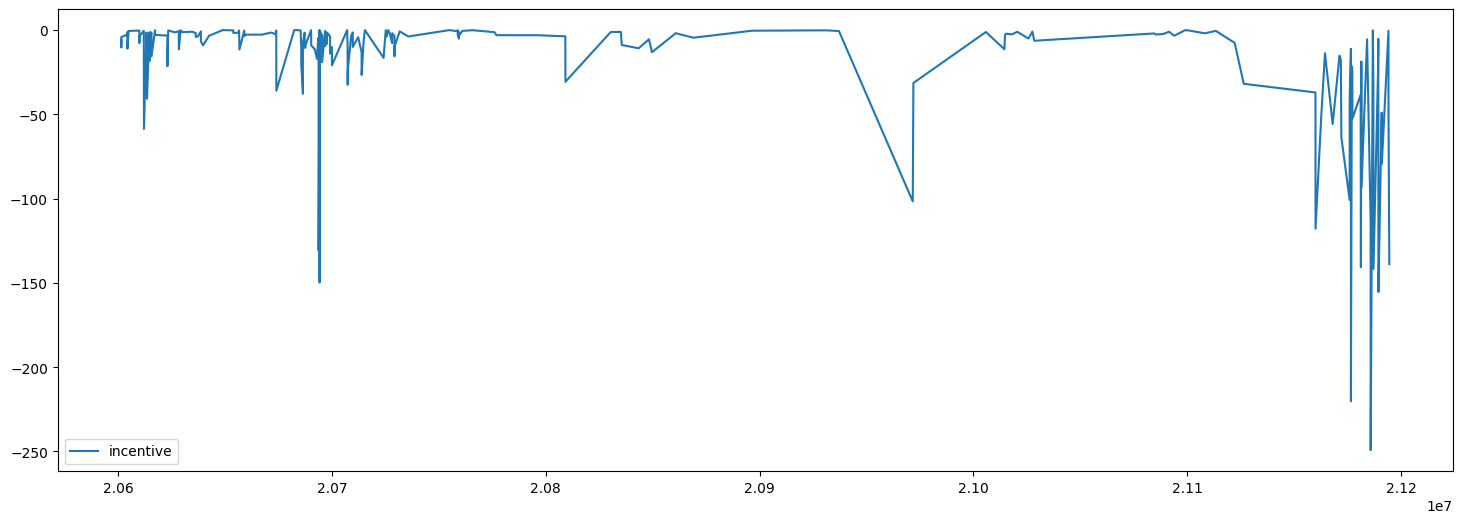

In [69]:
masked_df = joined_df[joined_df["incentive"] < 0]


plt.figure(figsize=(18, 6))
plt.plot(masked_df["blockNumber"], masked_df["incentive"], label="incentive")
plt.legend()
plt.show()

In [74]:
sorted_df = masked_df.sort_values(by="incentive", ascending=False)

# Convert masked_df to list of dictionaries
masked_df_list = sorted_df.to_dict(orient='records')


In [81]:
masked_df_list[-3]

{'blockNumber': 21189381,
 'transactionHash': '0x76cc40b1cb21e6acb61dd0c7b9496500188d29392bf689096236d115b6495d63',
 'crvUSD': 16897.328191183795,
 'collateral': -5.484949415615651,
 'price_oracle': 3052.3453832046703,
 'get_p': 3028.022660052322,
 'get_p_diff': 11.702826288401411,
 'delta': -24.322723152348317,
 'abs_delta': 24.322723152348317,
 'incentive': -155.36816531821023}

In [60]:
masked_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 258 entries, 5 to 1475
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   blockNumber      258 non-null    int64  
 1   transactionHash  258 non-null    object 
 2   crvUSD           258 non-null    float64
 3   collateral       258 non-null    float64
 4   price_oracle     258 non-null    float64
 5   get_p            258 non-null    float64
 6   get_p_diff       258 non-null    float64
 7   delta            258 non-null    float64
 8   abs_delta        258 non-null    float64
 9   incentive        258 non-null    float64
dtypes: float64(8), int64(1), object(1)
memory usage: 22.2+ KB
